In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
# import chart_studio
# import chart_studio.plotly as py
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# # plotly api key
# plotly_api_key = 'Dns1gp04h4QpiskQPFT3'
# chart_studio.tools.set_credentials_file(username='thamsuppp', api_key = plotly_api_key)

/home/isaac/.cache/pypoetry/virtualenvs/econdl-6MXPf6IA-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/isaac/.cache/pypoetry/virtualenvs/econdl-6MXPf6IA-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [103]:
Y_pred_big_latest.shape

(9, 3, 3, 40)

In [106]:
### Coding up the Y_pred_big_latest_shifted for MultiForecastEvaluation

# Y_pred_big_latest: model x horizon x n_var x n_test
Y_pred_big_latest = np.load('results/28sep_test/Y_pred_big_latest.npy')
Y_pred_big_latest_shifted = np.zeros_like(Y_pred_big_latest)
Y_pred_big_latest_shifted[:] = np.nan

# Conduct the shifting
for horizon in range(1, Y_pred_big_latest.shape[1]):
  Y_pred_big_latest_shifted[:, horizon, :, horizon:] = Y_pred_big_latest[:, horizon, :, :-horizon]

In [86]:
Y_pred_big_latest.shape

(9, 3, 3, 40)

In [10]:
results = np.load('results/28sep_test/params_0_compiled.npz', allow_pickle = True)['results'].item()

In [14]:
results['params']['s_pos']

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

In [4]:
data = pd.read_csv('data/quarterlyData_updated.csv')

In [5]:
data

,Unnamed: 0,y,L_0y,L_1y,L_2y,L_3y,L0_GDPC1,L0_PCECC96,L0_PCDGx,L0_PCESVx,...,L1_MARX_S.P.div.yield,L2_MARX_S.P.div.yield,L3_MARX_S.P.div.yield,L1_MARX_S.P.PE.ratio,L2_MARX_S.P.PE.ratio,L3_MARX_S.P.PE.ratio,L1_MARX_YLag,L2_MARX_YLag,L3_MARX_YLag,trend
0,6/1/1960,0.005990,0.000909,0.006035,0.005151,0.001723,0.022228,0.009521,0.031666,0.009030,...,0.15650,0.094600,0.052125,-0.059484,-0.045505,-0.025307,0.003472,0.004032,0.003454,1
1,9/1/1960,0.000565,0.005990,0.000909,0.006035,0.005151,-0.005405,0.012536,0.022501,0.010987,...,0.15770,0.133533,0.092850,-0.040860,-0.047772,-0.040216,0.003449,0.004311,0.004521,2
2,12/1/1960,0.006401,0.000565,0.005990,0.000909,0.006035,0.004882,-0.004005,-0.008030,-0.001192,...,0.05760,0.114333,0.107050,-0.011490,-0.026784,-0.035487,0.003277,0.002488,0.003374,3
3,3/1/1961,0.002013,0.006401,0.000565,0.005990,0.000909,-0.012917,0.001294,-0.025450,0.009610,...,0.02665,0.046967,0.092175,0.001083,-0.007394,-0.019889,0.003483,0.004318,0.003466,4
4,6/1/1961,-0.000335,0.002013,0.006401,0.000565,0.005990,0.006726,-0.000372,-0.056541,0.009791,...,-0.18160,-0.111867,-0.062000,0.064891,0.043717,0.026701,0.004207,0.002993,0.003742,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,6/1/2021,0.019673,0.010090,0.005540,0.011707,-0.008542,0.015222,0.027073,0.101297,0.009615,...,-0.14165,-0.181067,-0.112225,0.151364,0.161533,0.119959,0.007815,0.009112,0.004699,245
245,9/1/2021,0.016250,0.019673,0.010090,0.005540,0.011707,0.016274,0.028421,0.027461,0.027247,...,-0.13250,-0.133167,-0.164850,0.098181,0.114313,0.131202,0.014882,0.011768,0.011752,246
246,12/1/2021,0.019037,0.016250,0.019673,0.010090,0.005540,0.005693,0.004876,-0.070516,0.019805,...,-0.08410,-0.105667,-0.112875,-0.013000,0.043384,0.069182,0.017961,0.015338,0.012888,247
247,3/1/2022,0.022005,0.019037,0.016250,0.019673,0.010090,0.016668,0.006239,0.006165,0.008037,...,-0.03845,-0.064367,-0.085475,-0.088867,-0.045841,0.004657,0.017643,0.018320,0.016263,248


In [80]:
n_obs_total = 749
new_size = 749 - 12
indices_to_exclude = [(n_obs_total + i) for i in range(-31, -19, 1)]
indices_to_include = [e for e in range(n_obs_total) if e not in indices_to_exclude]

In [81]:
BETAS_ALL = np.zeros((749, 3, 3))
for i in range(749):
  BETAS_ALL[i,0,0] = i

In [82]:
BETAS_ALL = BETAS_ALL[indices_to_include, :, :]

In [84]:
BETAS_ALL[700:, 0,0]

array([700., 701., 702., 703., 704., 705., 706., 707., 708., 709., 710.,
       711., 712., 713., 714., 715., 716., 717., 730., 731., 732., 733.,
       734., 735., 736., 737., 738., 739., 740., 741., 742., 743., 744.,
       745., 746., 747., 748.])

In [40]:
# get the number of na values in each column
print(data.isna().sum().sort_values(ascending=False).iloc[0:50])

Unnamed: 0               0
L3_MARX_CIVPART          0
L1_MARX_CIVPART          0
L3_MARX_CE16OV           0
L2_MARX_CE16OV           0
L1_MARX_CE16OV           0
L3_MARX_CES9093000001    0
L2_MARX_CES9093000001    0
L1_MARX_CES9093000001    0
L3_MARX_CES9092000001    0
L2_MARX_CES9092000001    0
L1_MARX_CES9092000001    0
L3_MARX_CES9091000001    0
L2_MARX_CES9091000001    0
L1_MARX_CES9091000001    0
L3_MARX_USWTRADE         0
L2_MARX_USWTRADE         0
L1_MARX_USWTRADE         0
L3_MARX_USTRADE          0
L2_MARX_USTRADE          0
L1_MARX_USTRADE          0
L3_MARX_USGOVT           0
L2_MARX_USGOVT           0
L1_MARX_USGOVT           0
L3_MARX_USTPU            0
L2_MARX_CIVPART          0
L1_MARX_UNRATE           0
L1_MARX_USTPU            0
L2_MARX_UNRATE           0
L1_MARX_UEMP15T26        0
L3_MARX_UEMP5TO14        0
L2_MARX_UEMP5TO14        0
L1_MARX_UEMP5TO14        0
L3_MARX_UEMPLT5          0
L2_MARX_UEMPLT5          0
L1_MARX_UEMPLT5          0
L3_MARX_LNS14000026      0
L

In [4]:
data_old = pd.read_csv('data/monthlyData.csv')

In [14]:
data = pd.read_csv('data/quarterlyData_updated.csv')
# No need to difference the housing data
data = data.dropna()

x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L0_GDPC1', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'GDP', 'inf', 'unrate', 'house_starts']
exog_data = data[[e for e in data.columns if e not in ['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L0_GDPC1', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]]

In [8]:
data.columns

Index(['Unnamed: 0', 'y', 'L_0y', 'L_1y', 'L_2y', 'L_3y', 'L_4y', 'L_5y',
       'L_6y', 'L_7y',
       ...
       'L11_MARX_INVEST', 'L1_MARX_VIXCLSx', 'L2_MARX_VIXCLSx',
       'L3_MARX_VIXCLSx', 'L11_MARX_VIXCLSx', 'L1_MARX_YLag', 'L2_MARX_YLag',
       'L3_MARX_YLag', 'L11_MARX_YLag', 'trend'],
      dtype='object', length=1027)

In [ ]:
# Investigating Metric 

In [3]:
a = np.load('benchmark_multi_zero.npz')

In [9]:
with open(f'benchmark_multi_zero.npz', 'wb') as f:
  np.save(f, a)

In [ ]:
np.save('benchmark_multi_zero.npz', a)

In [19]:
import skopt.plots
import skopt

In [35]:
# sk_opt evaluation
skopt_results = skopt.load('results/7sep_bayesian_test2/opt_results.pkl')

In [36]:
skopt_results['x']

[0.0, 73, 2, 25, 169, 0.0, 0.004854307603918471, 'nn.ReLU()']

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

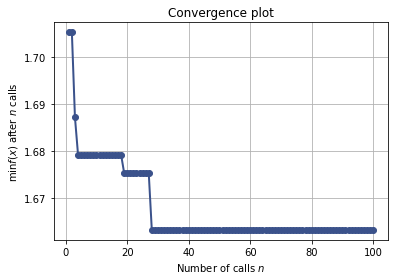

In [30]:
# Plots the best to-date result at each iteration
skopt.plots.plot_convergence(skopt_results)

array([[<AxesSubplot:xlabel='dropout_rate', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_width'>,
        <AxesSubplot:xlabel='nn_width', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='nn_depth', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='tvpl'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='tvpl', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='constant_tvpl'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='constant_tvpl'

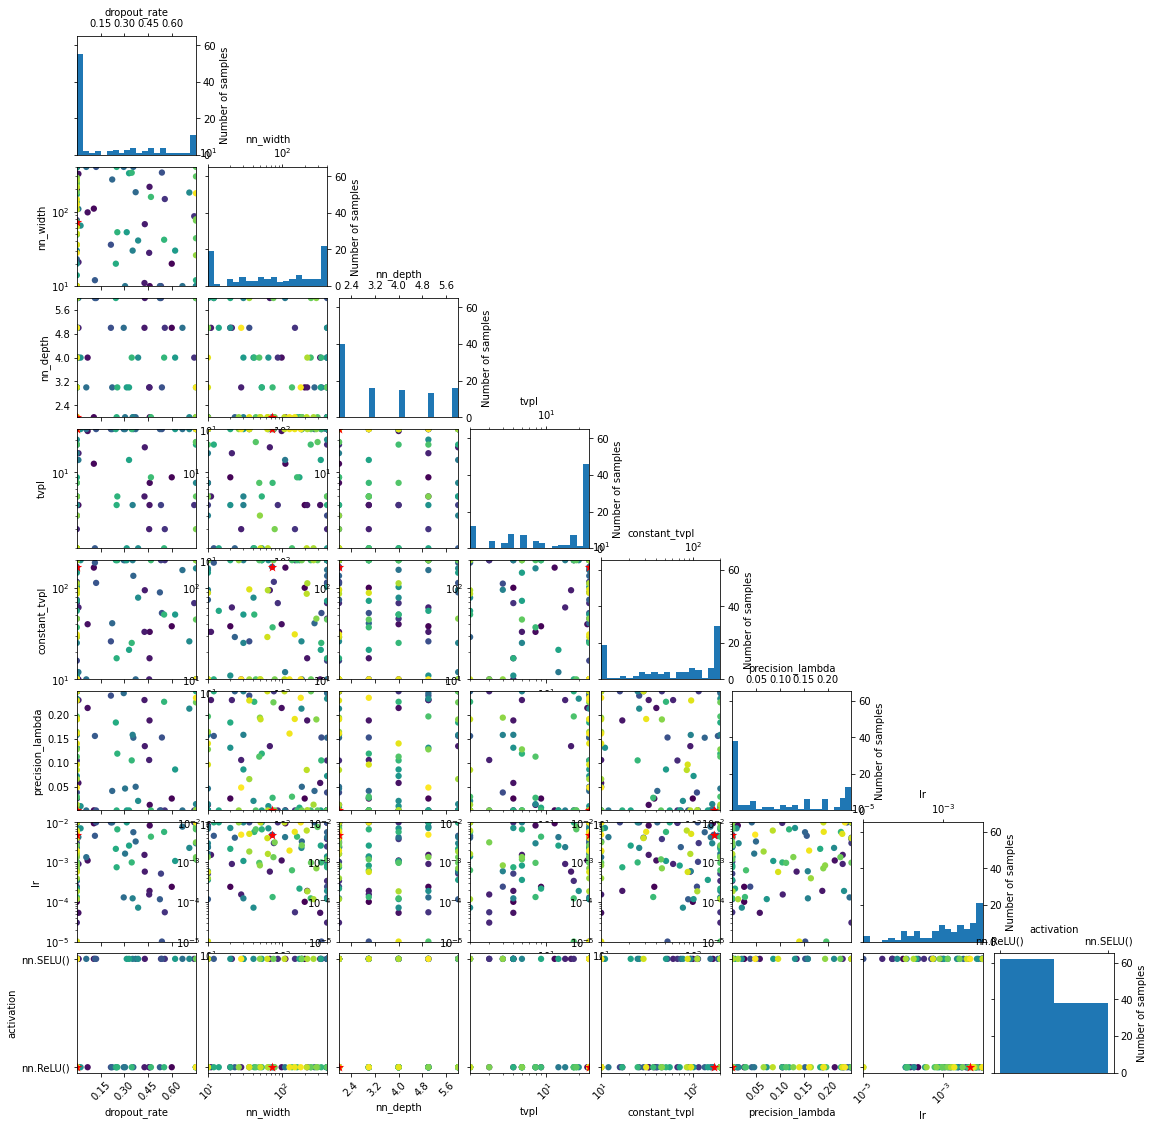

In [31]:
skopt.plots.plot_evaluations(skopt_results)

array([[<AxesSubplot:xlabel='dropout_rate', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_width'>,
        <AxesSubplot:xlabel='nn_width', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='nn_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='tvpl'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='tvpl', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='constant_tvpl'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='constant_t

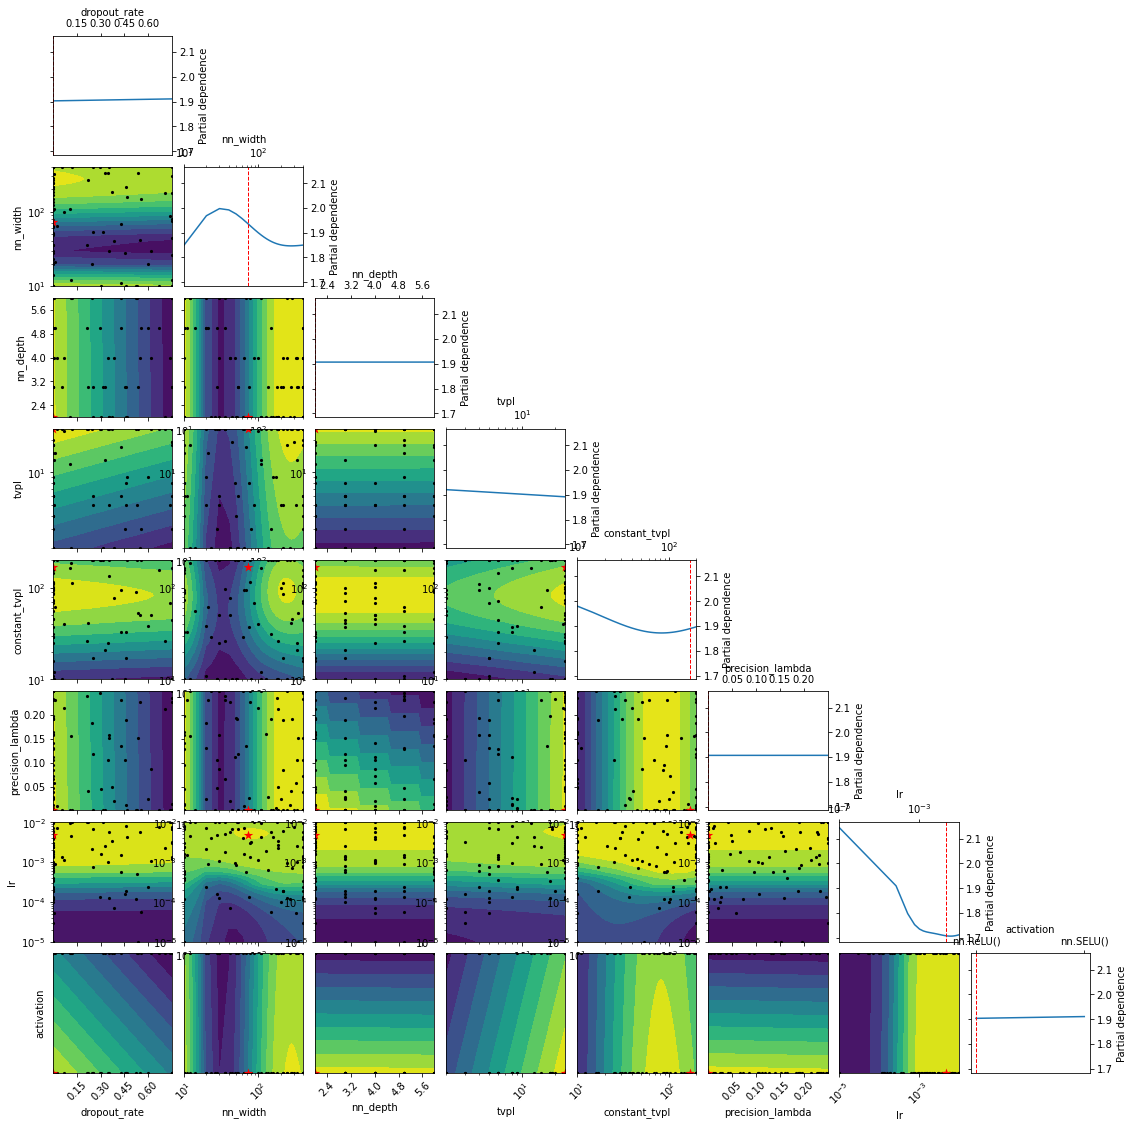

In [32]:
skopt.plots.plot_objective(skopt_results)

In [2]:
# Load npz file
irf = np.load('IRF_conditional.npz')['IRFS'] # (n_obs x n_bootstraps x n_var x n_var x max_h)
irf_median = np.nanmedian(irf, axis = 1) # (n_obs x n_var x n_var x max_h)

In [3]:
irf.shape

(242, 20, 3, 3, 10)

In [4]:
irf_one = irf_median[:, 0, 0, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

n_var = irf_median.shape[1]

In [8]:
# Plotly graph for conditional IRFs


fig = make_subplots(rows = 3, cols = 3,
                    subplot_titles = [f'IRF {k} -> {kk}' for k in range(n_var) for kk in range(n_var)],
                    specs = [[{'is_3d': True} for e in range(n_var)] for e in range(n_var)],
                    shared_xaxes = False,
                    shared_yaxes = False,
                    horizontal_spacing = 0,
                    vertical_spacing = 0.05
)

for k in range(n_var):
  for kk in range(n_var):
    
    fig.add_trace(go.Surface(name = 'Exp 1', z = irf_median[:, kk, k, :], showscale = False, showlegend = True, 
#          colorscale = [[0, px.colors.qualitative.Plotly[0]], [1, px.colors.qualitative.Plotly[0]]],
          colorscale = 'RdBu', cmid = 0,
          opacity = 0.7),
          row = k+1, col = kk+1)

    fig.add_trace(go.Surface(name = 'Exp 2', z = irf_median[:, kk, k, :] * 2 + 0.01, showscale = False, showlegend = True, 
#          colorscale = [[0, px.colors.qualitative.Plotly[0]], [1, px.colors.qualitative.Plotly[0]]],
          colorscale = 'RdBu', cmid = 0,
          opacity = 0.7),
          row = k+1, col = kk+1)

fig.update_scenes(xaxis_title = 'Horizon',
                  yaxis_title = 'Time', 
                  zaxis_title = 'Value',
                  camera = {
                  'up': {'x': 0, 'y': 0, 'z': 1},
                  'center': {'x': 0, 'y': 0, 'z': 0},
                  'eye': {'x': 1.25, 'y': -1.5, 'z': 0.75}
                  })


fig.update_layout(title='Conditional IRFs', autosize=False,
                  width = 1000, height=1000,
                  margin=dict(l=25, r=25, b=65, t=90))

fig.show()

fig.write_html('interactive_irf.html')

In [1]:
# Surface plots (non-interactiv)

fig = plt.figure(figsize = (5 * n_var, 5 * n_var), constrained_layout = True)

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 0
kk = 1
ax = fig.add_subplot(2, 2, 2, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 0
kk = 2
ax = fig.add_subplot(2, 2, 3, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 1
kk = 0
ax = fig.add_subplot(2, 2, 4, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

NameError: name 'plt' is not defined

In [51]:
fig = plt.figure(figsize = (8 * n_var, 8 * n_var))

for k in range(n_var):
  for kk in range(n_var):
    ax = fig.add_subplot(n_var, n_var, 1, projection = '3d')

    irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
    irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
    irf_unstacked.columns = ['horizon', 'time', 'value']

    surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.viridis, linewidth = 0.5)
    fig.colorbar(surf, shrink = 0.5, aspect = 10)
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Time')
    ax.set_zlabel('Value')
    ax.view_init(30, -60)
    ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

IndexError: GridSpec slice would result in no space allocated for subplot

<Figure size 1728x1728 with 0 Axes>

In [18]:
# Get the data (csv file is hosted on the web)
url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/volcano.csv'
data = pd.read_csv(url)

In [20]:
# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

In [21]:
df

,X,Y,Z
0,0,0,100
1,0,1,101
2,0,2,102
3,0,3,103
4,0,4,104
...,...,...,...
5302,57,82,94
5303,57,83,94
5304,57,84,94
5305,57,85,94


In [138]:
mses = pd.read_csv('results/22aug_test/images/mean_absolute_errors_test.csv')

In [131]:
# Load the single-horizon preds
single_results = np.load('results/22aug_test/params_0_repeat_0.npz', allow_pickle = True)['results'].item() # test_size x n_bootstraps x n_var
single_test_preds = single_results['test_preds']
multi_test_preds = np.load('results/22aug_test/multi_fcast_params_0_repeat_0.npz', allow_pickle = True)['fcast_all']  # horizons x variables x n_bootstraps x test_size x R
multi_test_preds = multi_test_preds[1, :, :, :, :, 0]

# single_test_preds and multi_test_preds are test_size x bootstraps x variables

In [111]:
multi_test_preds.shape

(3, 5, 3, 5)

In [61]:
# Linear Benchmarks
single_results = np.load('results/20aug_test/benchmarks/benchmark_AR_roll.npz')
single_test_preds = single_results['test_preds'] # dim: test_size v n_var (20 x 3)
multi_test_preds = np.load('results/20aug_test/benchmarks/benchmark_multi_AR_roll.npz') # dim: horizons x n_var x test_size x re-estimation_windows (3 x 3 x 20 x 1)
multi_test_preds = multi_test_preds[1, :, :, 0].T # get the h = 1 forecast

In [113]:
single_test_preds[0, :, 0]

array([-3.86319999, -0.81647318,  3.59194337])

In [114]:
multi_test_preds[0, 0, :, 0]

array([-0.06820658,  0.02875379,  0.06043018])

In [83]:
np.nanmedian(np.nanmedian(multi_test_preds[var_id, :, :, :], axis = 1), axis = 0)

array([ 0.00183539,  0.00226282,  0.00223812,  0.00206   ,  0.00160519,
        0.00273221,  0.00259527,  0.00262626,  0.00168764,  0.00199707,
        0.00171522,  0.00232965,  0.00192809,  0.00220579,  0.00205513,
       -0.04077439,  0.02465758, -0.00158895,  0.00030641,  0.00456997])

In [132]:
var_id = 0
t = 2
print(sorted(single_test_preds[t, :, var_id]))
print(np.nanmedian(single_test_preds[t, :, var_id]))
print(sorted(multi_test_preds[var_id, 0, :, t]))
print(np.nanmedian(multi_test_preds[var_id, 0, :, t]))

[-1.0286928866202423, 0.6738496232832968, 1.3990758760291484]
0.6738496232832968
[-1.0286928866202423, 0.6738496888763742, 1.399075351284529]
0.6738496888763742


In [91]:
multi_test_preds.shape

(3, 40, 10, 20)

[0.00044185168330027925, 0.0009372605838981426, 0.0012114921423261825, 0.0016944113640138105, 0.001822657946704952, 0.001848122084988785, 0.0018622406262559182, 0.002105983986625674, 0.0021605949393669714, 0.003917951471710088]
0.0018353900158468684


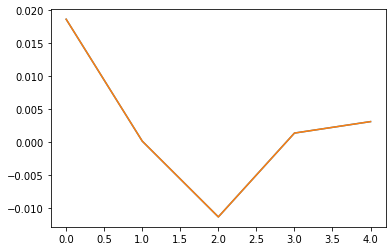

In [133]:
var_id = 0
plt.plot(np.nanmedian(single_test_preds[:, :, var_id], axis = 1))
plt.plot(np.nanmedian(np.nanmedian(multi_test_preds[var_id, :, :, :], axis = 1), axis = 0))